# Sharing numbers analysis

In [17]:
from __future__ import division, print_function
from IPython.display import display, HTML
import pandas as pd
import hashlib
import numpy as np
from math import log, exp, log10
import seaborn as sns
from scipy.optimize import minimize
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from Bio.Seq import translate 
from IPython.display import display, Math, Latex

For a given sequence $s$, $E(s) = -\log(p(s))$ is the Shannon surprise of generating a sequence $s$ at random. 

$g_{gen}(E)\  dE$ is the number of generated sequences whose surprise is between $E$ and $E + dE$. 

The density of states of the observed sequences will be written:
$$
    g(E) = g_{gen}\left(E - ln\left(\,f\,q\,\right)\right) \times f\,q
$$

Where $f$ is the proportion of functional sequences, in-frame, no stop codons or pseudogenes (for $\beta$, $0.236$ for humans), and $q$ is the selection factor that will be inferred from our data.

IGoR commands:
```bash
N=10000000
CMD='./path/to/igor -set_wd "../Datas/IGoR_gen/" -batch beta'
$CMD -species human -chain beta -generate $N
$CMD -read_seqs "../Datas/IGoR_gen/beta_generated/generated_seqs_werr.csv"
$CMD -species human -chain beta -align --all
$CMD -species human -chain beta -evaluate -output --Pgen

CMD='./path/to/igor -set_wd "../Datas/IGoR_gen/" -batch alpha'
$CMD -species human -chain alpha -generate $N
$CMD -read_seqs "../Datas/IGoR_gen/alpha_generated/generated_seqs_werr.csv"
$CMD -species human -chain alpha -align --all
$CMD -species human -chain alpha -evaluate -output --Pgen
```

# Sharing

In [52]:
def visualising_q(df_exp, df_gen, q):
    df_exp = df_exp.dropna(subset = ['amino']).copy()
    df_gen = df_gen.dropna(subset = ['amino']).copy()
    df_exp["isinframe"] = df_exp.sequence.apply(lambda x:len(str(x))%3 == 0)
    df_exp["stopcodon"] = df_exp.amino.apply(lambda x: ('*' in str(x)))
    df_gen["isinframe"] = df_gen.sequence.apply(lambda x:len(str(x))%3 == 0)
    df_gen["stopcodon"] = df_gen.amino.apply(lambda x: ('*' in str(x)))
    df_exp_prod = df_exp[df_exp.isinframe & ~df_exp.stopcodon].copy()
    df_gen_prod = df_gen[df_gen.isinframe & ~df_gen.stopcodon].copy()
    
    df_gen_prod["hash"] = df_gen_prod.amino.apply(
        lambda x: 
        int(hashlib.md5(str(x).encode('utf-8')).hexdigest()[:12],16)/int("F"*12,16))
    df_gen_post_selection = df_gen_prod[df_gen_prod.hash <= q]
#     print("Should be identical, else the hash is badly chosen:", len(set(df_gen_prod.hash)), len(set(df_gen_prod.amino)))
#     sns.distplot(df_gen_prod.hash,kde=False, norm_hist=True)
#     plt.title("Distribution of the hash between 0 and 1, should be flat")
#     plt.show()
    
    
    nb_mean = 5
    maxsize = min(len(df_gen_post_selection), len(df_exp_prod))
    size_samples = range(1000, maxsize, maxsize//10)
    
    print("Ratio of unique sequence on the total number of generated sequences")
    print(len(np.unique(df_gen.sequence))/len(df_gen))
    nb_unique_aa = []
    nb_unique_nuc = []
    nb_unique_aa_sim = []
    nb_unique_nuc_sim = []
    for size_sample in size_samples:
        tot = nt = tot_th = nt_th = 0
        for i in range(nb_mean):
            df_exp_sampled = df_exp_prod.sample(size_sample)
            df_gen_sampled = df_gen_post_selection.sample(size_sample)         
            tot += len(np.unique(df_exp_sampled.amino))
            tot_th += len(np.unique(df_gen_sampled.amino))
            nt += len(np.unique(df_exp_sampled.sequence))
            nt_th += len(np.unique(df_gen_sampled.sequence))
        nb_unique_aa.append(tot/nb_mean)
        nb_unique_nuc.append(nt/nb_mean)
        nb_unique_aa_sim.append(tot_th/nb_mean)
        nb_unique_nuc_sim.append(nt_th/nb_mean)
            
    #plt.plot(nb_unique_nuc, nb_unique_nuc, color='blue', linestyle=':')
    plt.plot(nb_unique_nuc_sim, nb_unique_aa_sim, color='red', linestyle=':')
    plt.plot(nb_unique_nuc, nb_unique_aa, color='green', linestyle=':')
    plt.show()


In [19]:
df_exp_beta = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_beta_X.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "___", "____", "_____"])
df_gen_beta = pd.read_csv("../Datas/sharing/gen_CDR3_beta_werr_inframe.tsv.gz", sep="\t",
                     header=None, names=["CDR3", "sequence", "amino", "___", "____", "_____"])
df_exp_alpha = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_alpha_X.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "___", "____", "_____"])
df_gen_alpha = pd.read_csv("../Datas/sharing/gen_CDR3_alpha_werr.tsv.gz", sep="\t",
                     header=None, names=["CDR3", "sequence", "amino", "___", "____", "_____"])

Ratio of unique sequence on the total number of generated sequences
0.8348639980027055


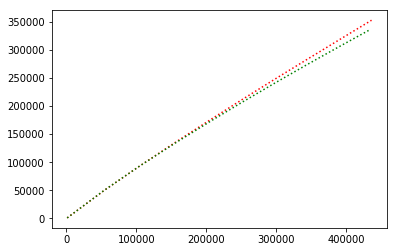

In [53]:
visualising_q(df_exp_alpha, df_gen_alpha, 0.6)

Ratio of unique sequence on the total number of generated sequences
0.975191303581346


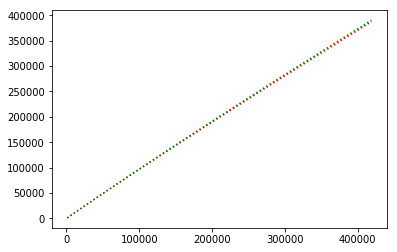

In [54]:
visualising_q(df_exp_beta, df_gen_beta, 0.1)

In [66]:
def estimating_q(df_exp, df_gen):
    df_exp["isinframe"] = df_exp.sequence.apply(lambda x:len(str(x))%3 == 0)
    df_exp["stopcodon"] = df_exp.amino.apply(lambda x: ('*' in str(x)))
    df_gen["isinframe"] = df_gen.sequence.apply(lambda x:len(str(x))%3 == 0)
    df_gen["stopcodon"] = df_gen.amino.apply(lambda x: ('*' in str(x)))
    df_exp_prod = df_exp[df_exp.isinframe & ~df_exp.stopcodon].copy()
    df_gen_prod = df_gen[df_gen.isinframe & ~df_gen.stopcodon].copy()
    
    df_gen_prod["hash"] = df_gen_prod.amino.apply(
        lambda x: 
        int(hashlib.md5(str(x).encode('utf-8')).hexdigest()[:12],16)/int("F"*12,16))

    df_gen.drop_duplicates(subset=["sequence"])
    df_exp.drop_duplicates(subset=["sequence"])
        
        
    maxsize = max(len(df_gen_prod), len(df_exp_prod))
    q0 = 0.3
    
#     errs = []
#     for q in np.arange(0.3, 0.9, 0.1):
#         errs.append(error(q, (int(maxsize*0.1)), df_exp_prod, df_gen_prod, 5))
    
#     plt.plot(np.arange(0.1, 0.9, 0.1), errs)
#     plt.show()
#     print("Minimization start:")
#     res = minimize(error, q0, (int(maxsize*0.01), df_exp_prod, df_gen_prod, 4), bounds=((0.01,0.8),)) 
#     q = res.x
#     print(q)
        
    for q in np.arange(0.1,0.9,0.1):
        nb_mean = 5
        result_exp = []
        result_gen = []
        df_gen_post_selection = df_gen_prod[(df_gen_prod.hash <= float(q))]
        size_samples = range(1000, int(maxsize*q)-int(maxsize*q)//10, int(maxsize*q)//10)
        for n in size_samples:
            aa_exp = aa_gen = 0
            for i in range(nb_mean):
                df_exp_sampled = df_exp_prod.sample(n, replace=True)
                df_gen_sampled = df_gen_post_selection.sample(n, replace=True)
                aa_gen += len(np.unique(df_gen_sampled.amino))
                aa_exp += len(np.unique(df_exp_sampled.amino))
            result_exp.append(aa_exp/nb_mean)
            result_gen.append(aa_gen/nb_mean)
        plt.plot(size_samples, result_exp, color='red', linestyle=':', lable=str(q))
    plt.plot(size_samples, result_gen, color='green', linestyle=':', label="exp")
    plt.legend()
    plt.show()
    
def error(q, n, dfe, dfg, nb_mean):
    aa_gen = aa_exp = 0
    dfg_ps = dfg[dfg.hash <= q]
    for i in range(nb_mean):
        dfe_sampled = dfe.sample(n)
        dfg_sampled = dfg_ps.sample(n)
        aa_gen += len(np.unique(dfg_sampled.amino))
        aa_exp += len(np.unique(dfe_sampled.amino))
    return (aa_gen/nb_mean - aa_exp/nb_mean)**2

In [67]:
estimating_q(df_exp_beta, df_gen_beta)

MemoryError: 